In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

import spl.functional as spf
from spl.generators import SSPGenerator

/Users/shaysnyder/opt/anaconda3/envs/vsa-ogm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -----------------------------
# Hyperparameter Configuration
# -----------------------------
axis_resolution: int = 128
axis_limit: int = 5
length_scale: int = 5
random_seed: int = 0
vsa_dimensions: int = 2048

device: str = torch.device("cpu")

In [3]:
# -----------------------------------
# Initialize Libraries and Utilities
# -----------------------------------
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

ssp_gen = SSPGenerator(
    dimensionality=vsa_dimensions,
    device=device
)

In [4]:
# -------------------------
# Specify Object Locations
# -------------------------
label_vectors: dict = {
    "class": spf.make_good_unitary(vsa_dimensions, device),
    "x": spf.make_good_unitary(vsa_dimensions, device),
    "time": spf.make_good_unitary(vsa_dimensions, device)
}

objects: dict = {
    "fox": {
        "locations": torch.tensor([[-4], [4]]),
        "symbol": spf.make_good_unitary(vsa_dimensions, device),
        "path": torch.linspace(1, 5, 4)
    }
}

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [5]:
# -----------------------------------
# Initialize Spatial Data Structures
# -----------------------------------
x_axis = torch.linspace(-axis_limit, axis_limit, axis_resolution, device=device)
x_axis = x_axis.reshape((-1, 1))

axis_basis_vectors: torch.tensor = ssp_gen.generate(1)
time_basis_vector: torch.tensor = ssp_gen.generate(1)

x_axis_matrix = torch.zeros((axis_resolution, vsa_dimensions), device=device)
for i, x in enumerate(x_axis):
    x_axis_matrix[i, :] = spf.power(axis_basis_vectors[0], x)

In [6]:
# --------------
# Create Memory
# --------------
memory = torch.zeros(vsa_dimensions, device=device)

for object_key in objects:
    symbol_vector: torch.tensor = objects[object_key]["symbol"]
    locations: torch.tensor = objects[object_key]["locations"]

    # encode each location is cartesian space to hyperdimensional space
    location_vectors = torch.zeros((locations.shape[0], vsa_dimensions))
    for i in range(locations.shape[0]):
        ubv = [spf.power(axis_basis_vectors[0], locations[i]), symbol_vector]
        memory += spf.bind(ubv, device=device)

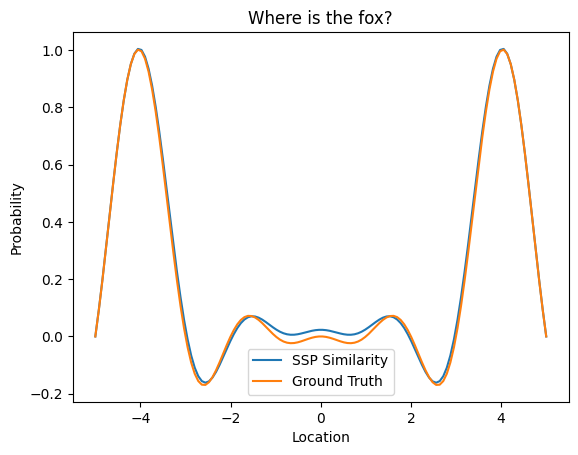

In [7]:
fox_decoded = spf.bind(
    vs=[memory, spf.invert(objects["fox"]["symbol"])],
    device=device
)
results = torch.sum(fox_decoded * x_axis_matrix, dim=1)

plt.title("Where is the fox?")
plt.plot(x_axis, results, label="SSP Similarity")
plt.plot(x_axis, np.sinc(x_axis + 4) + np.sinc(x_axis - 4), label="Ground Truth")
plt.xlabel("Location")
plt.ylabel("Probability")
plt.legend()

In [8]:
# ----------------------------------------------------------
# Associate each location of the fox with a given time step
# ----------------------------------------------------------
memory_time = torch.zeros(vsa_dimensions, device=device)

for object_key in objects:
    symbol_vector: torch.tensor = objects[object_key]["symbol"]
    locations: torch.tensor = objects[object_key]["locations"]

    # encode each location is cartesian space to hyperdimensional space
    location_vectors = torch.zeros((locations.shape[0], vsa_dimensions))
    for i in range(locations.shape[0]):
        vs = [
            spf.power(axis_basis_vectors[0], locations[i]),
            spf.power(time_basis_vector, i),
            objects["fox"]["symbol"]
        ]
        memory_time += spf.bind(vs, device)

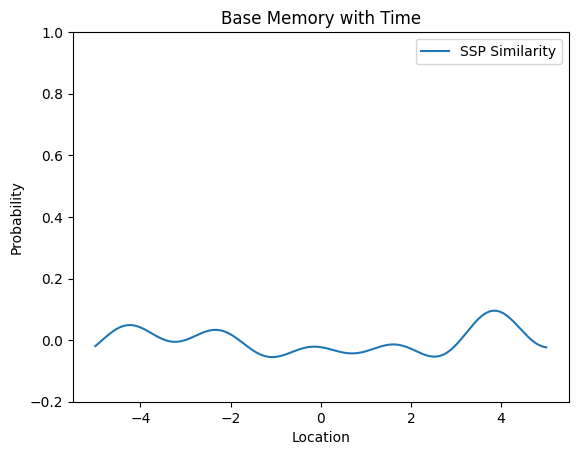

In [9]:
results = torch.sum(memory * x_axis_matrix, dim=1)
plt.title("Base Memory with Time")
plt.plot(x_axis, results, label="SSP Similarity")
plt.xlabel("Location")
plt.ylabel("Probability")
plt.ylim(-0.2, 1)
plt.legend()

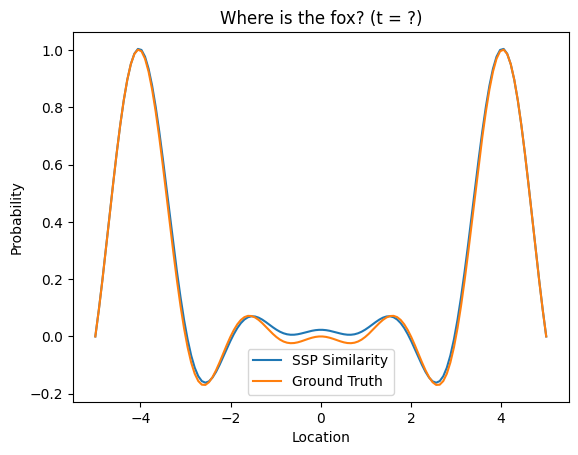

In [10]:
vs = [memory, spf.invert(objects["fox"]["symbol"])]
fox_decoded = spf.bind(vs, device)
results = torch.sum(fox_decoded * x_axis_matrix, dim=1)

plt.title("Where is the fox? (t = ?)")
plt.plot(x_axis, results, label="SSP Similarity")
plt.plot(x_axis, np.sinc(x_axis + 4) + np.sinc(x_axis - 4), label="Ground Truth")
plt.xlabel("Location")
plt.ylabel("Probability")
plt.legend()

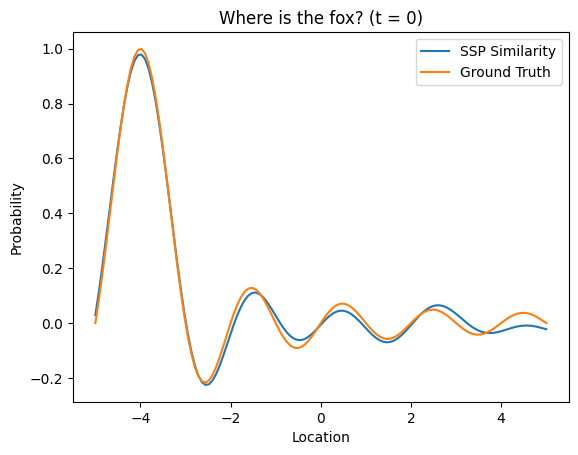

In [11]:
vs = [spf.power(time_basis_vector[0], 0), objects["fox"]["symbol"]]
query = spf.bind(vs, device)
query = spf.invert(query)

vs = [memory_time, query]
fox_decoded = spf.bind(vs, device)

results = torch.sum(fox_decoded * x_axis_matrix, dim=1)

plt.title("Where is the fox? (t = 0)")
plt.plot(x_axis, results, label="SSP Similarity")
plt.plot(x_axis, np.sinc(x_axis + 4), label="Ground Truth")
plt.xlabel("Location")
plt.ylabel("Probability")
plt.legend()

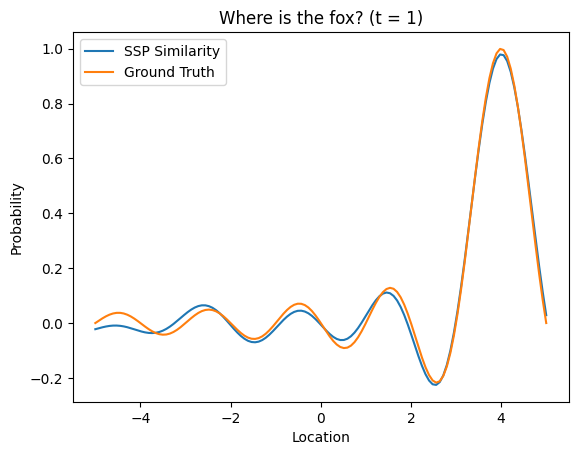

In [12]:
vs = [spf.power(time_basis_vector[0], 1), objects["fox"]["symbol"]]
query = spf.bind(vs, device)
query = spf.invert(query)

vs = [memory_time, query]
fox_decoded = spf.bind(vs, device)

results = torch.sum(fox_decoded * x_axis_matrix, dim=1)

plt.title("Where is the fox? (t = 1)")
plt.plot(x_axis, results, label="SSP Similarity")
plt.plot(x_axis, np.sinc(x_axis - 4), label="Ground Truth")
plt.xlabel("Location")
plt.ylabel("Probability")
plt.legend()